In [1]:
import subprocess
import time
import requests
import os
import json
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
CACHITO_ASYNCIO_PATH = "/home/fepas/red-hat/cachito_tests/cachito_asyncio"
CACHITO_THREAD_PATH = "/home/fepas/red-hat/cachito_tests/cachito_threads"
password_file = "/home/fepas/red-hat/cachito-worker-performance-test/password.txt"

In [3]:
#utils
def delete_tmp_folder(folder):
    command = f"cd {folder} && sudo -S rm -rf {folder}/tmp < {password_file}"
    reponse = !{command}
    print(f"deleted: tmp folder on {folder}")

def wait_until_cachito_is_up():
    while True:
        r = False
        try:
            r = requests.get('http://localhost:8080/api/v1/status/short')
        except:
            pass
        if (r and r.status_code == 200):
            print("done! cachito is online!")
            break
        else:
            print("waiting...")
            time.sleep(5)
            
def build_cachito(folder):
    delete_tmp_folder(folder)
    with open(f"/{folder}/output.log", "a") as output:
        subprocess.call(f"cd {folder} && make run &", shell=True, stdout=output, stderr=output)
        print(f"cachito on {folder} is building")
        wait_until_cachito_is_up()
        
def stop_cachito(folder):
    print(f"cachito on {folder} is going down")
    subprocess.call(f"cd {folder} && make run-down &", shell=True)

    while True:
        cachito_containers = !{docker ps -a}
        if (len(cachito_containers) == 1):
            print("done! cachito is down!")
            break
        else:
            print("waiting...")
            time.sleep(5)
              
def get_docker_stats(filename, overwrite=False):
    
    mode = "a"
    if overwrite:
        mode = "w"
        
    stats = !{docker stats --no-stream -a} 
    content = ""
    for line in stats:
            content += line
            content += "\n"
            
    with open(filename, mode) as file_object:
        file_object.write(content)


In [4]:
def cachito_test_1(branch, stats_interval=10):
    #Heavy request with 3159 deps
    
    REQUEST = "CACHITO_REQUEST_1"
    
    data = {
      "repo": "https://github.com/stackrox/stackrox.git",
      "ref": "834e3ad9ea0337b8e1d859b230370161a69986eb",
      "pkg_managers": [
        "git-submodule",
        "yarn"
      ],
      "packages": {
        "yarn": [
          {
            "path": "ui"
          },
          {
            "path": "docs/tools/antora-bundle"
          },
          {
            "path": "docs/tools/site-generator"
          }
        ]
      },
      "flags": [
        "include-git-dir"
      ]
    }
    
    url = "http://localhost:8080/api/v1"
    headers = {'Content-type': 'application/json'}
    
    #make the request to cachito
    cachito_request = requests.post(url=f"{url}/requests", data=json.dumps(data), headers=headers)
    cachito_request_id = cachito_request.json()["id"]
    
    get_docker_stats(f"{REQUEST}_{branch}.csv", overwrite=True)
    while True:
        time.sleep(stats_interval)
        get_docker_stats(f"{REQUEST}_{branch}.csv")
        cachito_response = requests.get(url=f"{url}/requests/{cachito_request_id}", headers=headers)
        if cachito_response.json()["state"] == "complete":   
            break


### Run *asyncio* approach tests

In [5]:
build_cachito(CACHITO_ASYNCIO_PATH)

deleted: tmp folder on /home/fepas/red-hat/cachito_tests/cachito_asyncio
cachito on /home/fepas/red-hat/cachito_tests/cachito_asyncio is building
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
done! cachito is online!


In [6]:
cachito_test_1("asyncio")

In [7]:
stop_cachito(CACHITO_ASYNCIO_PATH)

cachito on /home/fepas/red-hat/cachito_tests/cachito_asyncio is going down
waiting...
docker-compose down -v


Container cachito_asyncio-cachito-worker-1  Stopping
Container cachito_asyncio-athens-1  Stopping
Container cachito_asyncio-cachito-worker-1  Stopping
Container cachito_asyncio-athens-1  Stopping
Container cachito_asyncio-athens-1  Stopped
Container cachito_asyncio-athens-1  Removing
Container cachito_asyncio-athens-1  Removed
Container cachito_asyncio-cachito-worker-1  Stopped
Container cachito_asyncio-cachito-worker-1  Removing
Container cachito_asyncio-cachito-worker-1  Removed
Container cachito_asyncio-cachito-api-1  Stopping
Container cachito_asyncio-nexus-1  Stopping
Container cachito_asyncio-cachito-api-1  Stopping
Container cachito_asyncio-rabbitmq-1  Stopping
Container cachito_asyncio-rabbitmq-1  Stopping
Container cachito_asyncio-nexus-1  Stopping


waiting...


Container cachito_asyncio-cachito-api-1  Stopped
Container cachito_asyncio-cachito-api-1  Removing
Container cachito_asyncio-cachito-api-1  Removed
Container cachito_asyncio-db-1  Stopping
Container cachito_asyncio-db-1  Stopping
Container cachito_asyncio-db-1  Stopped
Container cachito_asyncio-db-1  Removing
Container cachito_asyncio-db-1  Removed
Container cachito_asyncio-nexus-1  Stopped
Container cachito_asyncio-nexus-1  Removing
Container cachito_asyncio-nexus-1  Removed


waiting...


Container cachito_asyncio-rabbitmq-1  Stopped
Container cachito_asyncio-rabbitmq-1  Removing
Container cachito_asyncio-rabbitmq-1  Removed
Volume cachito_asyncio_cachito-request-logs  Removing
Volume cachito_asyncio_athens-storage  Removing
Volume cachito_asyncio_cachito-archives  Removing
Network cachito_asyncio_default  Removing
Volume cachito_asyncio_cachito-request-logs  Removed
Volume cachito_asyncio_athens-storage  Removed
Volume cachito_asyncio_cachito-archives  Removed
Network cachito_asyncio_default  Removed


done! cachito is down!


### Run *thread* approach tests

In [25]:
build_cachito(CACHITO_THREAD_PATH)

deleted: tmp folder on /home/fepas/red-hat/cachito_tests/cachito_threads
cachito on /home/fepas/red-hat/cachito_tests/cachito_threads is building
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
done! cachito is online!


In [26]:
cachito_test_1("thread")

In [24]:
stop_cachito(CACHITO_THREAD_PATH)

cachito on /home/fepas/red-hat/cachito_tests/cachito_threads is going down
waiting...
docker-compose down -v


Container cachito_threads-cachito-worker-1  Stopping
Container cachito_threads-cachito-worker-1  Stopping
Container cachito_threads-athens-1  Stopping
Container cachito_threads-athens-1  Stopping
Container cachito_threads-cachito-worker-1  Stopped
Container cachito_threads-cachito-worker-1  Removing
Container cachito_threads-athens-1  Stopped
Container cachito_threads-athens-1  Removing
Container cachito_threads-athens-1  Removed
Container cachito_threads-cachito-worker-1  Removed
Container cachito_threads-cachito-api-1  Stopping
Container cachito_threads-rabbitmq-1  Stopping
Container cachito_threads-rabbitmq-1  Stopping
Container cachito_threads-nexus-1  Stopping
Container cachito_threads-cachito-api-1  Stopping
Container cachito_threads-nexus-1  Stopping
Container cachito_threads-rabbitmq-1  Stopped
Container cachito_threads-rabbitmq-1  Removing
Container cachito_threads-cachito-api-1  Stopped
Container cachito_threads-cachito-api-1  Removing
Container cachito_threads-nexus-1  Stopp

done! cachito is down!


### Analysis

In [45]:
import re

def get_only_characters(string):
    return re.sub('[^a-zA-Z]+', '', string)

def get_only_numbers(string):
    return float(re.sub('[^\d\.]', '', string))

def to_bit(value):
    return int({
        "b": get_only_numbers(value) * 1,
        "kib": get_only_numbers(value) * 10e3,
        "kb": get_only_numbers(value) * 10e3,
        "mib": get_only_numbers(value) * 10e6,
        "mb": get_only_numbers(value) * 10e6,
        "gib": get_only_numbers(value) * 10e9,
        "gb": get_only_numbers(value) * 10e9,
    }.get(get_only_characters(value).lower(), 0))

def percentage_to_float(df_col):
    return df_col.apply(lambda x: float(x[0:-1]))

In [107]:
asyncio_df = pd.read_csv("CACHITO_REQUEST_1_asyncio.csv", delimiter=r"\s\s+", engine="python")
asyncio_df = asyncio_df[asyncio_df.NAME != "NAME"]
asyncio_df = asyncio_df[asyncio_df.NAME != "cachito_asyncio-cachito-api-1"]
asyncio_df = asyncio_df[asyncio_df.NAME != "cachito_asyncio-athens-1"]
asyncio_df = asyncio_df[asyncio_df.NAME != "cachito_asyncio-db-1"]
asyncio_df["mem_percentage"] = percentage_to_float(asyncio_df["MEM %"])
asyncio_df["cpu_percentage"] = percentage_to_float(asyncio_df["CPU %"])
asyncio_df["PIDS"] = pd.to_numeric(asyncio_df["PIDS"])

In [60]:
thread_df.NAME.unique()

array(['cachito_threads-cachito-worker-1',
       'cachito_threads-cachito-api-1', 'cachito_threads-rabbitmq-1',
       'cachito_threads-nexus-1', 'cachito_threads-db-1',
       'cachito_threads-athens-1'], dtype=object)

In [108]:
thread_df = pd.read_csv("CACHITO_REQUEST_1_thread.csv", delimiter=r"\s\s+", engine="python")
thread_df = thread_df[thread_df.NAME != "NAME"]
thread_df = thread_df[thread_df.NAME != "cachito_threads-cachito-api-1"]
thread_df = thread_df[thread_df.NAME != "cachito_threads-athens-1"]
thread_df = thread_df[thread_df.NAME != "cachito_threads-db-1"]
thread_df["mem_percentage"] = percentage_to_float(thread_df["MEM %"])
thread_df["cpu_percentage"] = percentage_to_float(thread_df["CPU %"])
thread_df["PIDS"] = pd.to_numeric(thread_df["PIDS"])

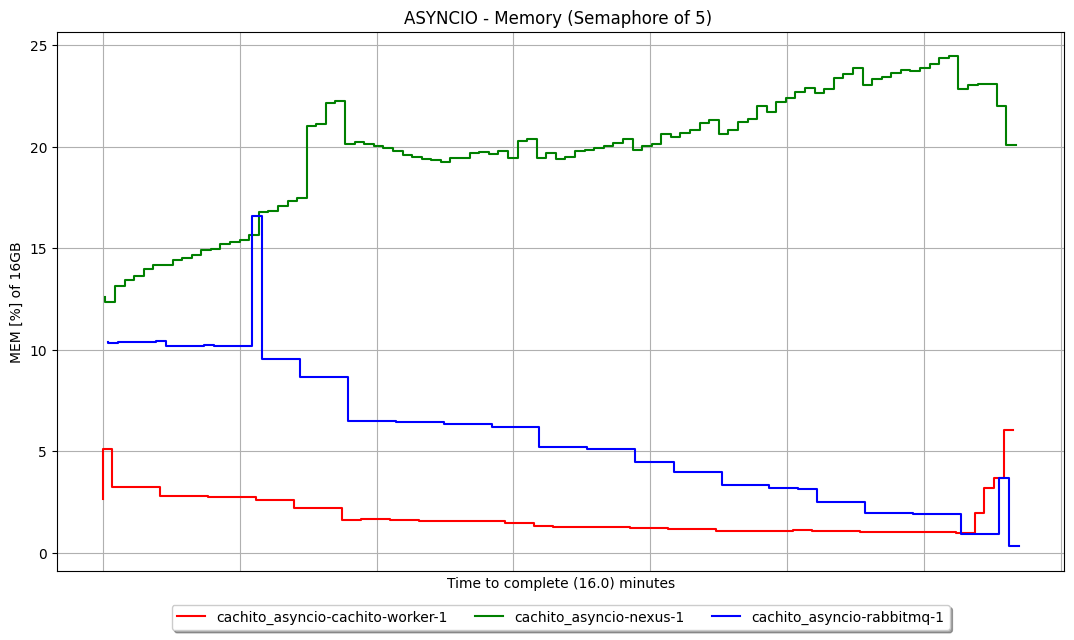

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=asyncio_df.index, y="mem_percentage", hue="NAME", data=asyncio_df, palette=['r', 'g', 'b'], drawstyle="steps")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("MEM [%] of 16GB")
time_to_complete = int(asyncio_df.shape[0])/len(asyncio_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"ASYNCIO - Memory (Semaphore of 5) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()

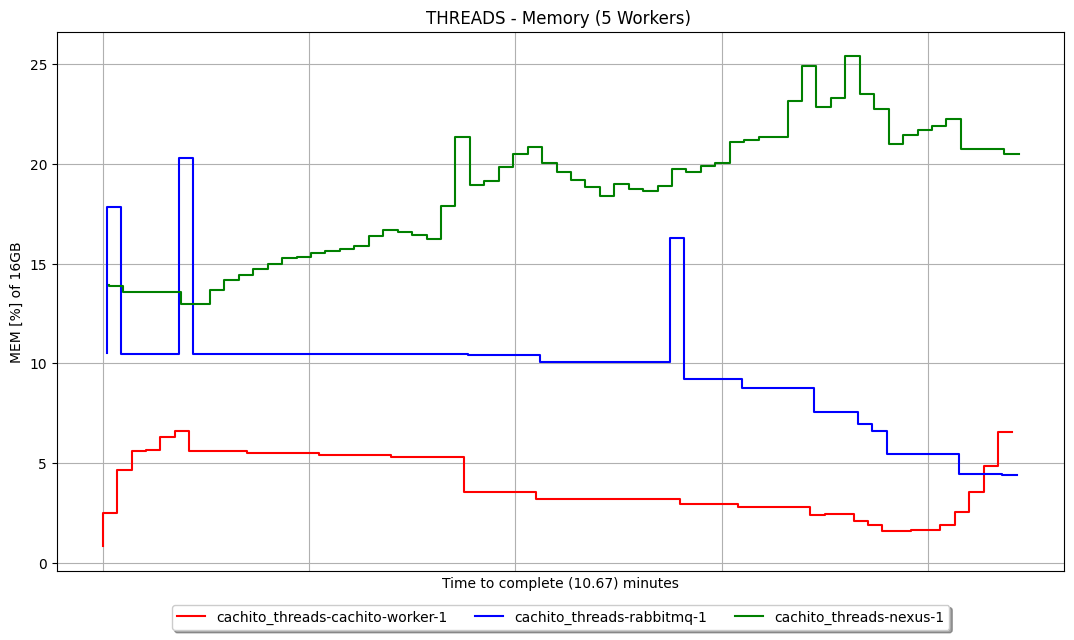

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=thread_df.index, y="mem_percentage", hue="NAME", 
              data=thread_df, palette=['r', 'b', 'g'] ,drawstyle="steps")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("MEM [%] of 16GB")
time_to_complete = int(thread_df.shape[0])/len(thread_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"THREADS - Memory (5 Workers) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()

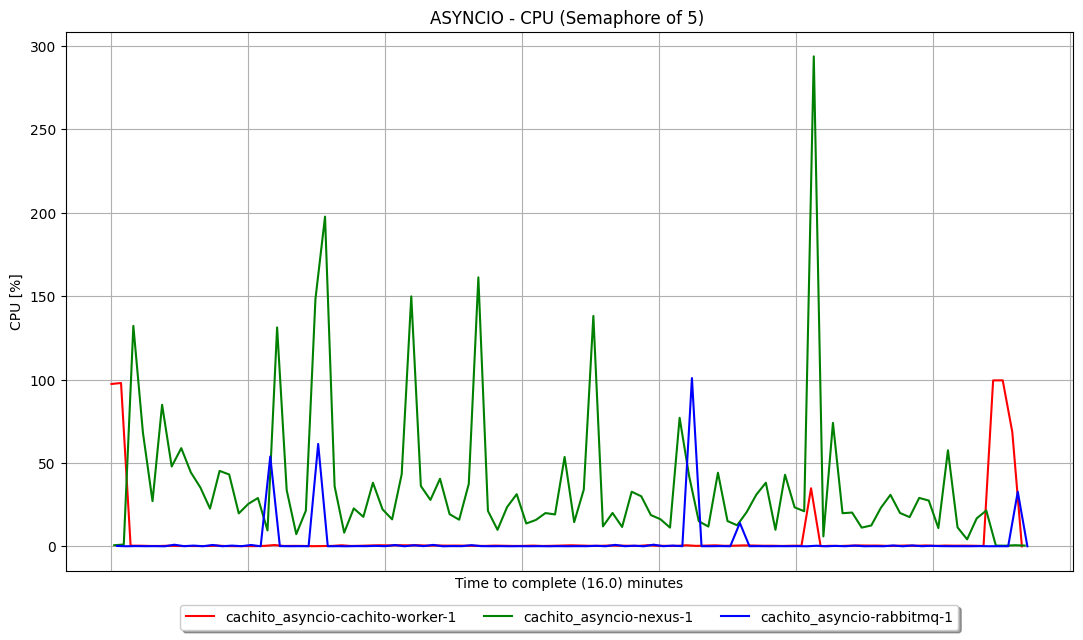

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=asyncio_df.index, y="cpu_percentage", hue="NAME", data=asyncio_df, palette=['r', 'g', 'b'],
            )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("CPU [%]")
time_to_complete = int(asyncio_df.shape[0])/len(asyncio_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"ASYNCIO - CPU (Semaphore of 5) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()

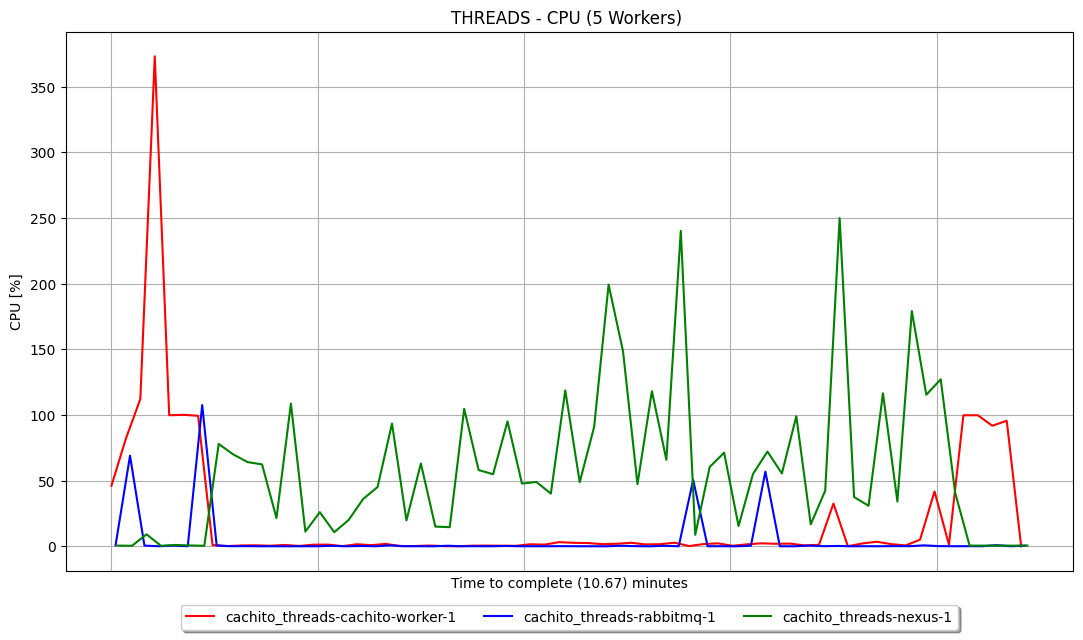

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=thread_df.index, y="cpu_percentage", hue="NAME", data=thread_df, palette=['r', 'b', 'g'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("CPU [%]")
time_to_complete = int(thread_df.shape[0])/len(thread_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"THREADS - CPU (5 Workers) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()

In [96]:
thread_df

,CONTAINER ID,NAME,CPU %,MEM USAGE / LIMIT,MEM %,NET I/O,BLOCK I/O,PIDS,mem_percentage,cpu_percentage
0,b129c0206ab3,cachito_threads-cachito-worker-1,46.20%,129.4MiB / 15.5GiB,0.82%,15.1MB / 156kB,38.5MB / 352kB,12,0.82,46.20
2,3cb718cedcb7,cachito_threads-rabbitmq-1,0.89%,1.63GiB / 15.5GiB,10.51%,66.6kB / 52.8kB,46.7MB / 6.21MB,37,10.51,0.89
3,dcf3763c4940,cachito_threads-nexus-1,0.64%,2.155GiB / 15.5GiB,13.91%,68.6kB / 16.5kB,218MB / 316MB,88,13.91,0.64
7,b129c0206ab3,cachito_threads-cachito-worker-1,82.06%,394.6MiB / 15.5GiB,2.49%,225MB / 818kB,38.5MB / 49MB,14,2.49,82.06
9,3cb718cedcb7,cachito_threads-rabbitmq-1,69.05%,2.763GiB / 15.5GiB,17.83%,70.4kB / 56.6kB,46.7MB / 6.28MB,41,17.83,69.05
...,...,...,...,...,...,...,...,...,...,...
436,3cb718cedcb7,cachito_threads-rabbitmq-1,0.15%,703.2MiB / 15.5GiB,4.43%,295kB / 279kB,59.9MB / 7.16MB,37,4.43,0.15
437,dcf3763c4940,cachito_threads-nexus-1,0.59%,3.215GiB / 15.5GiB,20.74%,261MB / 161MB,327MB / 2.38GB,135,20.74,0.59
441,b129c0206ab3,cachito_threads-cachito-worker-1,0.07%,1.02GiB / 15.5GiB,6.58%,913MB / 6.53MB,1.51GB / 4.16GB,7,6.58,0.07
443,3cb718cedcb7,cachito_threads-rabbitmq-1,0.62%,697.7MiB / 15.5GiB,4.40%,300kB / 283kB,60MB / 7.43MB,37,4.40,0.62


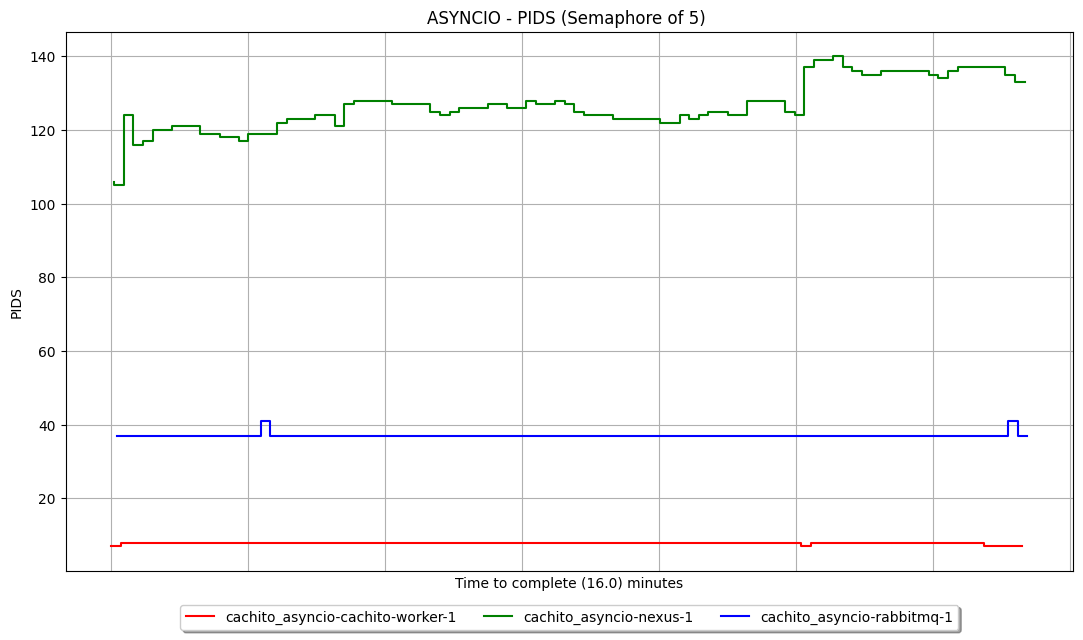

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=asyncio_df.index, y="PIDS", hue="NAME", data=asyncio_df, palette=['r', 'g', 'b']
            ,drawstyle="steps")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("PIDS")
time_to_complete = int(asyncio_df.shape[0])/len(asyncio_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"ASYNCIO - PIDS (Semaphore of 5) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()

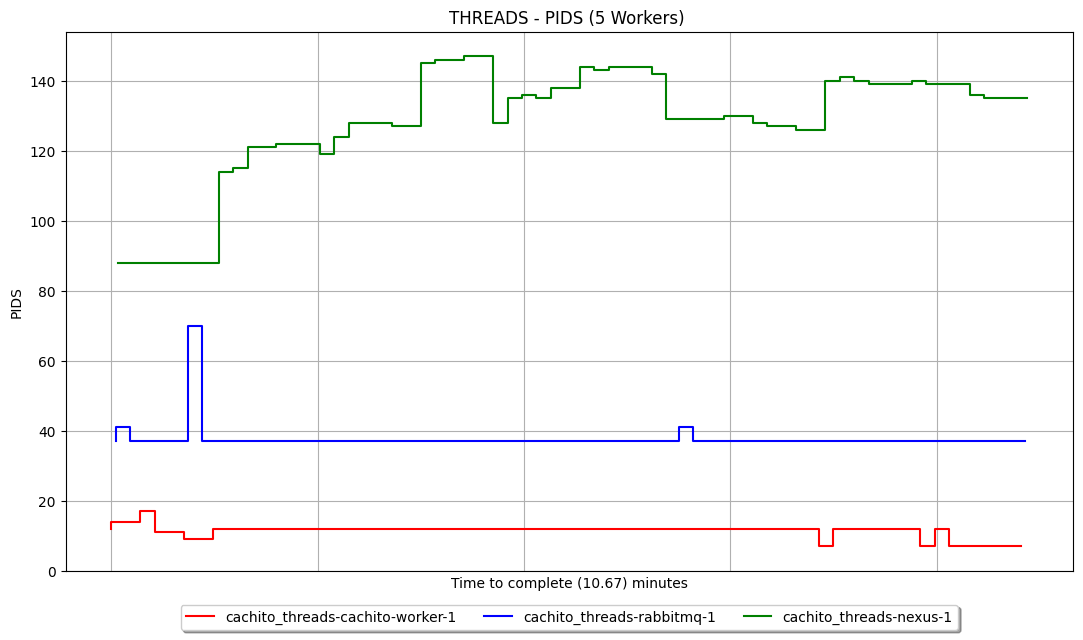

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

sns.lineplot(x=thread_df.index, y="PIDS", hue="NAME", data=thread_df, palette=['r', 'b', 'g'],
            drawstyle="steps")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel("PIDS")
time_to_complete = int(thread_df.shape[0])/len(thread_df.NAME.unique()) * 10 / 60
plt.xlabel(f"Time to complete ({round(time_to_complete, 2)}) minutes")
plt.title(f"THREADS - PIDS (5 Workers) ")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()